# MBA em Ciência de Dados - TCC
# Predição da Radiação Solar para Produção de Hidrogênio Verde: Análise comparativa de métodos de Aprendizado de Máquina

## Modelagem e Predição
**Material Produzido por:** Mateus Vasconcelos Albuquerque

**Cemeai - ICMC/USP São Carlos**


---------------------------------------------------------------------------------------------------------





## **CRISP-DS**

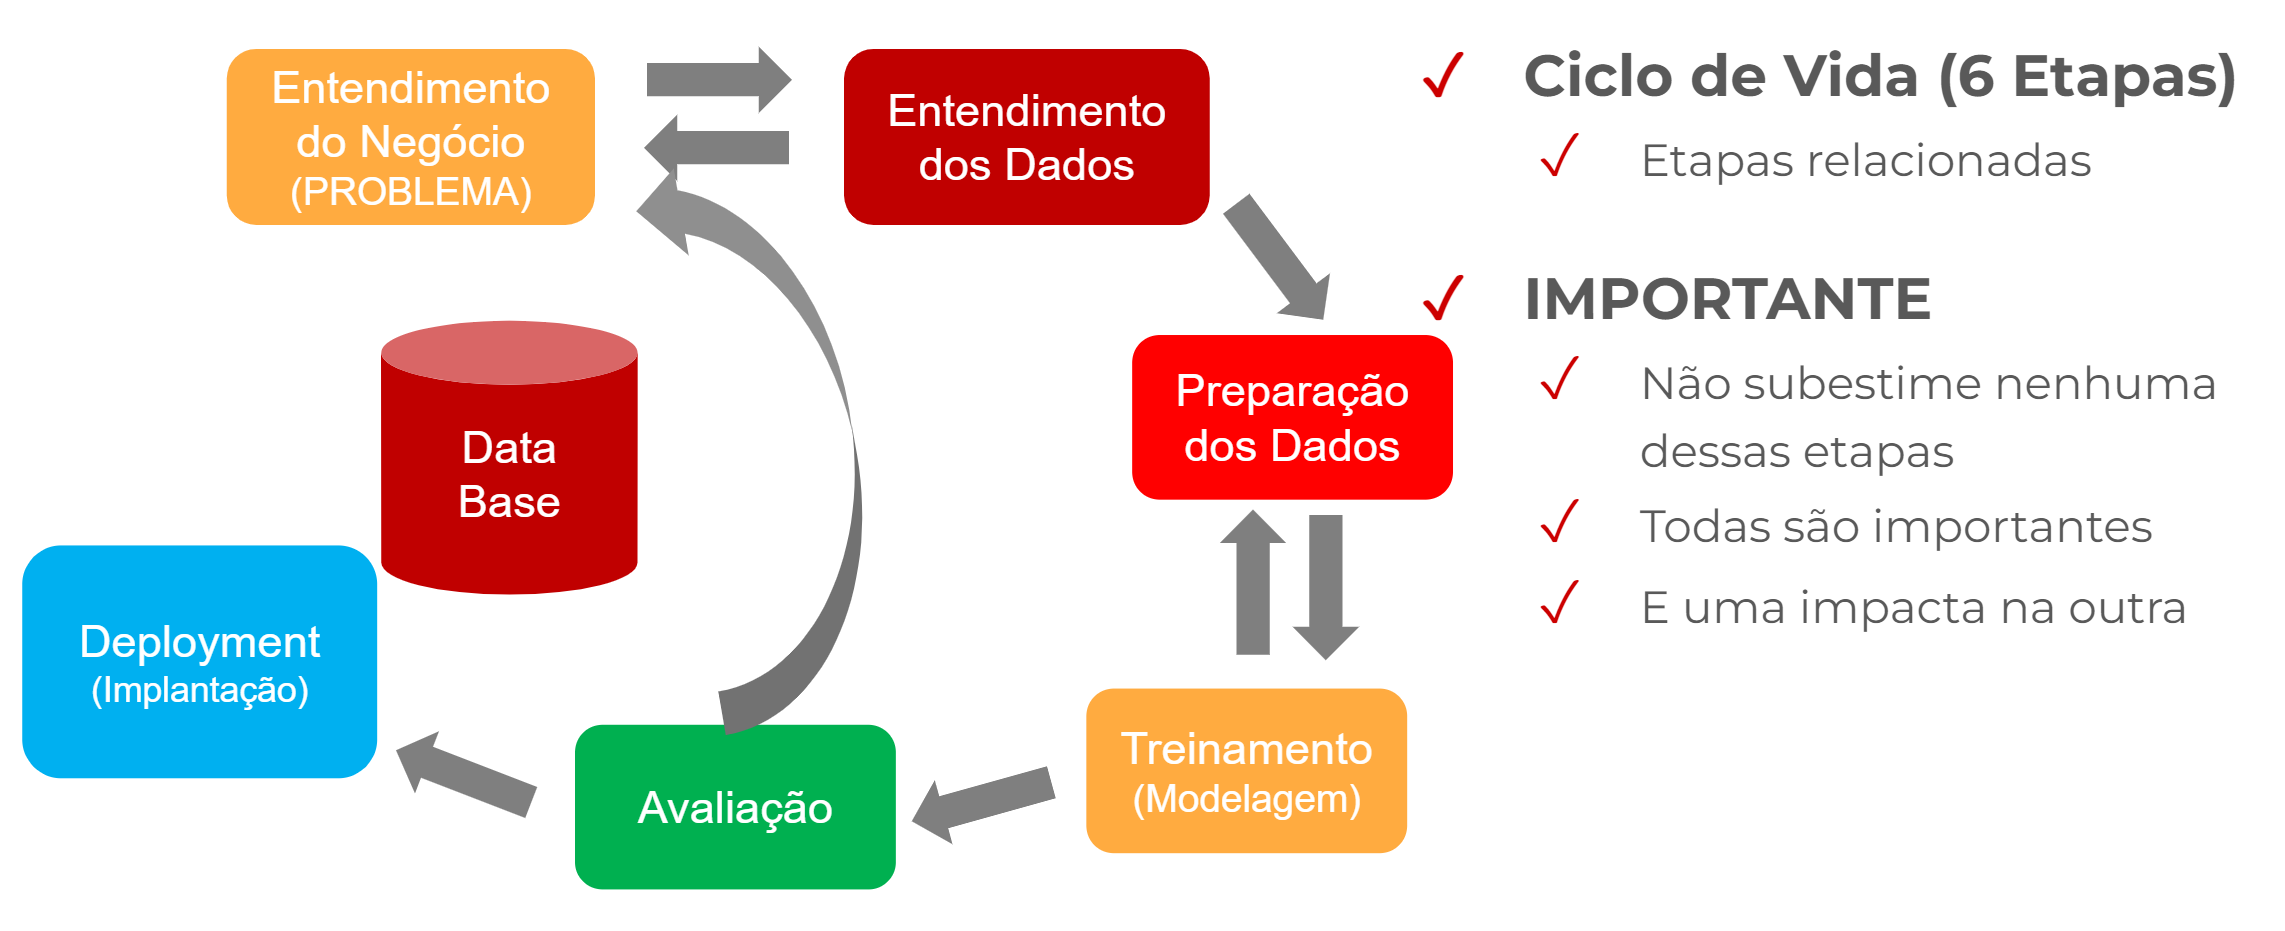

In [1]:
from google.colab import drive
import os

# Monta o Google Drive
drive.mount('/content/drive')

# Define o caminho da pasta 'Projetos'
projetos_path = '/content/drive/My Drive/MBA/TCC/Projeto'

# Define o diretório de trabalho para a pasta 'Projetos'
if os.path.exists(projetos_path):
    os.chdir(projetos_path)
    print(f"Diretório alterado para: {projetos_path}")
else:
    print(f"A pasta 'Projetos' não foi encontrada em: {projetos_path}")

Mounted at /content/drive
Diretório alterado para: /content/drive/My Drive/MBA/TCC/Projeto


## **3. Preparação dos Dados**

### 3.1. Import dos dados pré-processados

In [2]:
import pandas as pd
from pandas.plotting import lag_plot
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import yaml
import os

In [3]:
# Leitura do arquivo de configuração

# folder para carregar os config files
CONFIG_PATH = "config/"

# Função para carregar os dados
def load_config(config_name):
    with open(os.path.join(CONFIG_PATH, config_name)) as file:
        config = yaml.safe_load(file)

    return config

In [4]:
config = load_config("data_preprocessing_config_sobral.yaml")

# mostrar todas as colunas
pd.set_option("display.max_columns", None)

In [5]:
# Leitura dos dados a partir do CSV
codigo_wmo = config["input_data_parameters"]["codigo_wmo"]
estacao = config["input_data_parameters"]["estacao"]

input_dir = config["output_directory_preprocessing"]

filepath = f"{input_dir}/preprocessed_data_{codigo_wmo}_{estacao}.csv"

data = pd.read_csv(
    filepath,
    index_col=0,
)

# # remove last 5 columns
# data = data.iloc[:, :-5]

### 3.2. Scaling dos dados

In [6]:
features_target = ["precipitacao_total_horario", "pressao_atmosferica_nivel_estacao_horaria", "temperatura_ar_bulbo_seco_horaria", "umidade_relativa_ar_horaria", "vento_direcao_horaria", "vento_rajada_maxima", "vento_velocidade_horaria", "radiacao_global"]
data = data[features_target]

# Separar variável target e features
target = 'radiacao_global'
X = data.drop(columns=[target])
y = data[target]

In [8]:
from sklearn.preprocessing import MinMaxScaler
# Escalar os dados
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

### 3.3. Preparação dos dados para LSTM

LSTMs esperam os dados no formato de 3 dimensões: (amostras, timesteps, features).

In [9]:
# Definição do número de timesteps (quantidade de passos anteriores usados para prever)
timesteps = 24  # 24 horas anteriores

# Criar sequências para treino
X_lstm, y_lstm = [], []

for i in range(timesteps, len(X_scaled)):
    X_lstm.append(X_scaled[i-timesteps:i])
    y_lstm.append(y_scaled[i])

X_lstm, y_lstm = np.array(X_lstm), np.array(y_lstm)

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_lstm, y_lstm, test_size=0.3, shuffle=False)

### 3.4. Modelagem - LSTM simples

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(50, return_sequences=False),
    Dense(25, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [22]:
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

Epoch 1/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 37s 33ms/step - loss: 0.0225 - val_loss: 0.0078
Epoch 2/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 30s 32ms/step - loss: 0.0088 - val_loss: 0.0072
Epoch 3/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 40s 30ms/step - loss: 0.0075 - val_loss: 0.0071
Epoch 4/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 41s 30ms/step - loss: 0.0071 - val_loss: 0.0059
Epoch 5/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 43s 32ms/step - loss: 0.0066 - val_loss: 0.0065
Epoch 6/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 30s 31ms/step - loss: 0.0063 - val_loss: 0.0053
Epoch 7/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 39s 29ms/step - loss: 0.0059 - val_loss: 0.0053
Epoch 8/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 41s 29ms/step - loss: 0.0057 - val_loss: 0.0059
Epoch 9/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 42s 30ms/step - loss: 0.0058 - val_loss: 0.0053
Epoch 10/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 29s 31ms/step - loss: 0.0055 - val_loss: 0.0051
Epoch 11/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 41s 30ms/step - loss: 0.0053 - val_loss: 0.0055
Epoch 12/50
959/959 ━━━━━━━━━━

### 3.5 Predições e Avaliação

In [23]:
y_pred = model.predict(X_test)

# Inverter a escala para os valores originais
y_pred_original = scaler_y.inverse_transform(y_pred)
y_test_original = scaler_y.inverse_transform(y_test)

411/411 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step


In [27]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import numpy as np

mae = mean_absolute_error(y_test_original, y_pred_original)
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
mape = mean_absolute_percentage_error(y_test_original, y_pred_original) * 100

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}")

MAE: 174.35252204845054
RMSE: 322.49179399734385
MAPE: 2.2522512406196992e+18


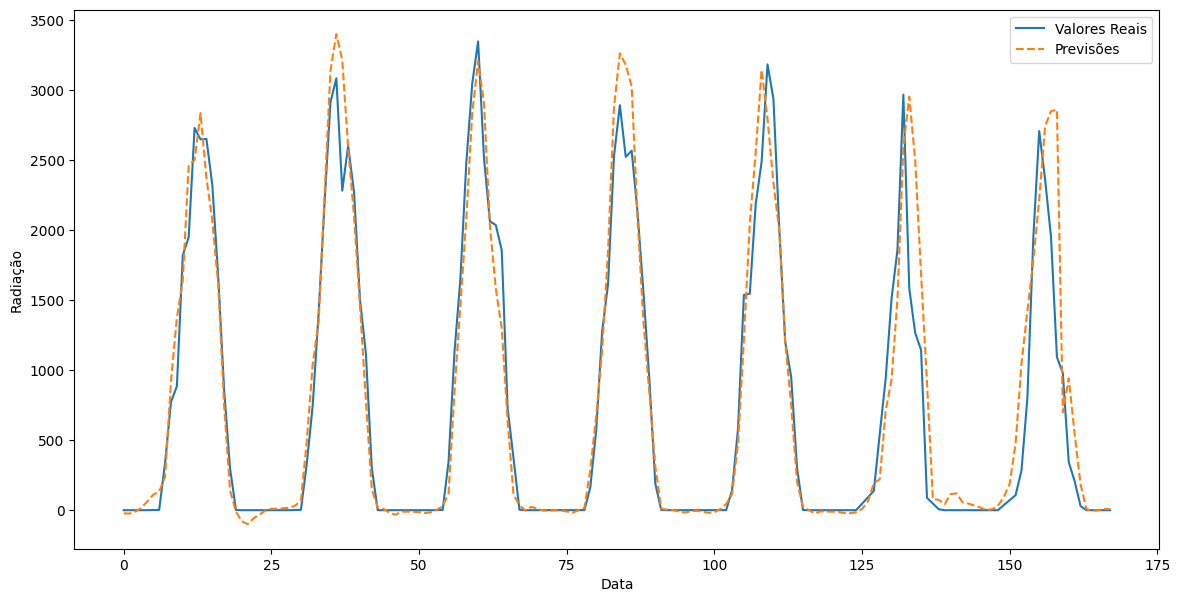

In [26]:
# Selecionando os últimos 7 * 24 valores para visualização
last_values = 7 * 24
Y_ts_last = y_test_original[-last_values:]
preds_lstm_last = y_pred_original[-last_values:]

# Plotando os últimos valores
plt.figure(figsize=(14, 7))

# Comparando a primeira coluna (ou ajusta conforme a quantidade de targets)
plt.plot(Y_ts_last, label='Valores Reais')
plt.plot(preds_lstm_last, label='Previsões', linestyle='--')

# plt.title('Predição vs Valores Reais (Últimos 7 dias)')
plt.xlabel('Data')
plt.ylabel('Radiação')
plt.legend()
plt.show()